# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Read CSV

In [ ]:
df = pd.read_csv('wewo.csv')
df = df[df["year"] > 1]
df['playoff'] = df['playoff'].map({'N':0,'Y':1})

team_df = pd.read_csv('../data/teams.csv')

# Analysis

### Distribution of playoffs

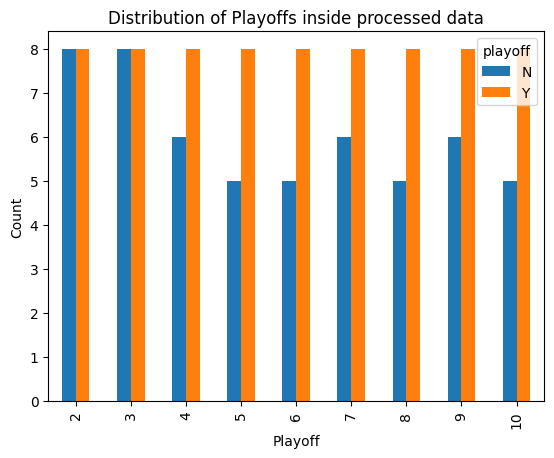

In [3]:
label_distribution = df.groupby(['year', 'playoff']).size().unstack()

label_distribution.plot(kind='bar')
plt.title('Distribution of Playoffs inside processed data')
plt.xlabel('Playoff')
plt.ylabel('Count')

plt.show()


### Correlation Matrix

In [ ]:
tempdf = df.drop(columns='tmID', axis=1)
print(list(tempdf.columns))

['year', 'playoff', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'dq', 'Award Count', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostDQ', 'coach_wr', 'coach_pwr', 'PostthreeRatio', 'PostfgRatio', 'PostftRatio', 'ThreeRatio', 'fgRatio', 'ftRatio']


In [9]:
correlation = tempdf.corr()
plt.figure(figsize=(20, 20))
plt.matshow(correlation, fignum=1)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.colorbar()

plt.show()

ValueError: could not convert string to float: 'N'

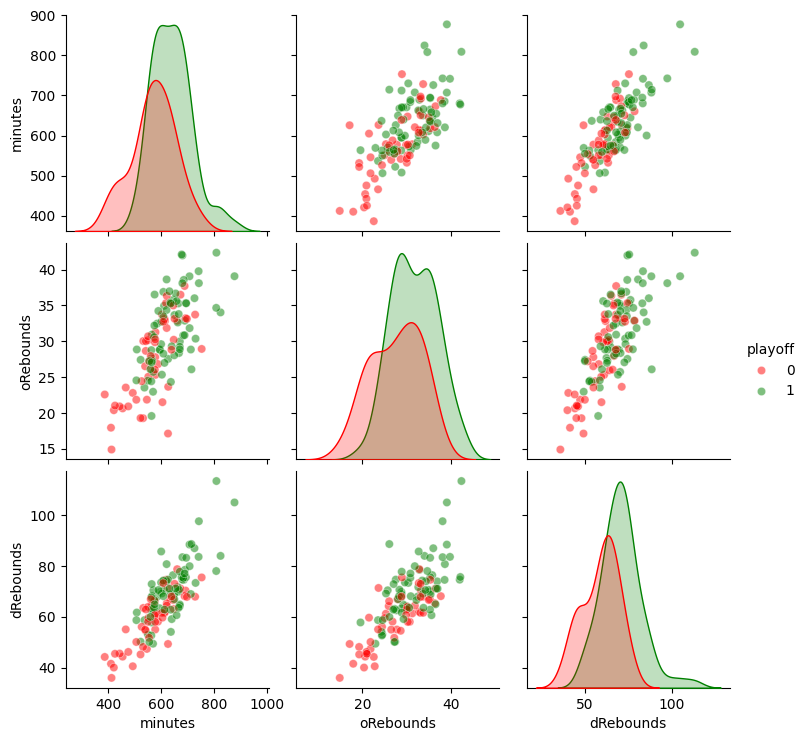

In [ ]:
sample_size = df.__len__()

attributes = ["playoff", "minutes", "oRebounds", "dRebounds"]

sample = df.sample(sample_size)[attributes]

palette = {0: 'red', 1: 'green'}
sb.pairplot(sample, hue='playoff', palette=palette, plot_kws={'alpha': 0.5})